# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# GET FILES, UNZIP, RENAME FOLDER
#!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

In [2]:
#from zipfile import ZipFile
#with ZipFile('dogImages.zip', 'r') as zipObj:
#   zipObj.extractall('data')
#!rm -r dogImages.zip

In [3]:
# with ZipFile('lfw.zip', 'r') as zipObj:
#    zipObj.extractall('data')
# !rm -r lfw.zip

In [4]:
#import os
#os.rename("data/dogImages","data/dog_images")

In [5]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


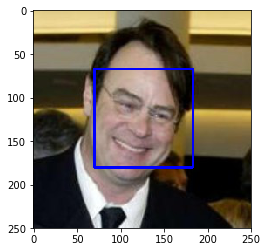

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 98 percent of human faces was detected as face.
- 17 percent of dog images was detected as face.

In [8]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def detector_runner(images, detector, data_topic="unknown"):
    '''
    With the decoder and a folder of images returns the accuracy of the decoder 
    Args:
        images: path to folder
        detector: detector function
        data_topic: what are the images about
    Return:
        accuracy of the decoder
    '''
    counter = 0
    for image in tqdm(images):
        if detector(image):
            counter +=1
    accuracy = counter / len(images)
    print(f"Percentage classified RIGHT by the detector for {data_topic}: {accuracy} with {detector} .")

# check the face_detector
detector_runner(human_files_short, face_detector, 'faces') 
detector_runner(dog_files_short, face_detector, 'dogs')

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage classified RIGHT by the detector for faces: 0.98 with <function face_detector at 0x7fecb8951a60> .


100%|██████████| 100/100 [00:29<00:00,  3.43it/s]

Percentage classified RIGHT by the detector for dogs: 0.17 with <function face_detector at 0x7fecb8951a60> .


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 127235206.19it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
from PIL import Image
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # build the transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    data_transform = transforms.Compose([transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    
    # get the image 
    img_pil = Image.open(img_path)
    #imshow(np.asarray(img_pil))
    
    # convert to proper input tensor, don't use alpha channel (gives error with png)
    img_tensor = data_transform(img_pil)[:3,:,:]
    img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # run trough vgg16
    output = VGG16(img_tensor)
    
    # get most probable class
    score, class_idx = torch.topk(output, k=1, dim=1)
    
    return class_idx.data.cpu().numpy()[0][0] # predicted class index

# test function
VGG16_predict('data/dog_images/test/016.Beagle/Beagle_01150.jpg')

162

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    idx = VGG16_predict(img_path)
    return True if 151 <= idx <= 268 else False # true/false

# test function
dog_detector('data/dog_images/test/016.Beagle/Beagle_01150.jpg')

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 1 percent of human files was classified as dog with the dog_detector.
- 90 percent of dog files was classified as dog with the dog_detector.

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# check the dog_detector
detector_runner(human_files_short, dog_detector, 'faces') 
detector_runner(dog_files_short, dog_detector, 'dogs')

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage classified RIGHT by the detector for faces: 0.01 with <function dog_detector at 0x7fb29c757598> .


100%|██████████| 100/100 [00:04<00:00, 24.70it/s]

Percentage classified RIGHT by the detector for dogs: 0.9 with <function dog_detector at 0x7fb29c757598> .


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [13]:
import os
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# image folders
train_dir = 'data/dog_images/train/'
valid_dir = 'data/dog_images/valid/'
test_dir = 'data/dog_images/test/'

normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

# transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(30),
                                       transforms.ToTensor(),
                                       normalization])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            normalization])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=validation_transforms) # same transform for validation

# define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size =20,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size =20,shuffle = True)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [14]:
# check loader
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)

torch.Size([20])
torch.Size([20, 3, 224, 224])


In [15]:
print("classes: " + str(len(train_data.classes)))

classes: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I choosed CenterCrop for all datasets (train, validation, test), because usually the most important features in dog photos are in the center of the image. I choosed size 224x224, because later I will compare this with a pretrainde network, which requires this size.
- For augmentation I used a not too large rotation, which isn't too weird, so original images could have similar angels. I used RandomHorizontalFlip, because the output of a horizontal flip is a very realistic, but a different image as well.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 14 * 14 -> 1000)
        self.fc1 = nn.Linear(128 * 14 * 14, 1000)
        # linear layer (1000 -> 133)
        self.fc2 = nn.Linear(1000, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # flatten image input
        x = x.view(-1, 128 * 14 * 14)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
- In the initializer we define the layers as instance variables.
- The foreward() function determines the subsequent steps.
- I choosed four convolutional layers, a maxpool layer after each of the convolutional layers to decrease the size of the tensor during the pass-rhrough.
- The last convolutional layer gives back a batchsizex128x14x14 tensor. Because the fully connected layer need batchsizexinpute_nodes tensor, with the view function I flatten the tensor to get the proper size. 
- For the fully connected layers I use dropout to avoid overfitting.
- The last fully connected layers outputs 133 scores, because we have 133 dogbreeds in our training set. Our goal is to find the most probable ones. Applying a softmax function on the output would give us the probabilities, but I output here only the scores, because later I want use cross-entropy loss.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # loss containers for chart
    train_losses = []
    valid_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # foreward pass the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        # update loss lists
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # plot losses
        if epoch % 5 == 0:
            plt.plot(train_losses, label='Training loss')
            plt.plot(valid_losses, label='Validation loss')
            plt.legend(frameon=False)
            plt.show()
            
    # return trained model
    return model

Epoch: 1 	Training Loss: 4.880575 	Validation Loss: 4.850596
Validation loss decreased (inf --> 4.850596).  Saving model ...
Epoch: 2 	Training Loss: 4.711434 	Validation Loss: 4.527241
Validation loss decreased (4.850596 --> 4.527241).  Saving model ...
Epoch: 3 	Training Loss: 4.480083 	Validation Loss: 4.400374
Validation loss decreased (4.527241 --> 4.400374).  Saving model ...
Epoch: 4 	Training Loss: 4.356104 	Validation Loss: 4.374179
Validation loss decreased (4.400374 --> 4.374179).  Saving model ...
Epoch: 5 	Training Loss: 4.235553 	Validation Loss: 4.273184
Validation loss decreased (4.374179 --> 4.273184).  Saving model ...


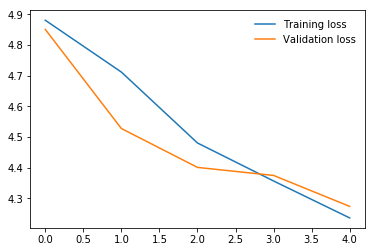

Epoch: 6 	Training Loss: 4.125217 	Validation Loss: 4.096732
Validation loss decreased (4.273184 --> 4.096732).  Saving model ...
Epoch: 7 	Training Loss: 4.002134 	Validation Loss: 4.056860
Validation loss decreased (4.096732 --> 4.056860).  Saving model ...
Epoch: 8 	Training Loss: 3.891992 	Validation Loss: 3.944340
Validation loss decreased (4.056860 --> 3.944340).  Saving model ...
Epoch: 9 	Training Loss: 3.765251 	Validation Loss: 3.879528
Validation loss decreased (3.944340 --> 3.879528).  Saving model ...
Epoch: 10 	Training Loss: 3.658613 	Validation Loss: 3.812644
Validation loss decreased (3.879528 --> 3.812644).  Saving model ...


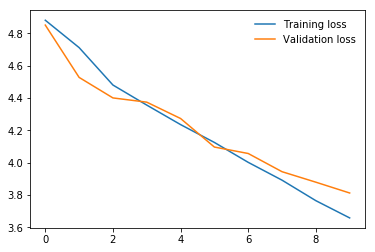

Epoch: 11 	Training Loss: 3.514178 	Validation Loss: 3.950668
Epoch: 12 	Training Loss: 3.416915 	Validation Loss: 3.765210
Validation loss decreased (3.812644 --> 3.765210).  Saving model ...
Epoch: 13 	Training Loss: 3.274123 	Validation Loss: 3.849477
Epoch: 14 	Training Loss: 3.129676 	Validation Loss: 4.021354
Epoch: 15 	Training Loss: 2.995640 	Validation Loss: 3.748278
Validation loss decreased (3.765210 --> 3.748278).  Saving model ...


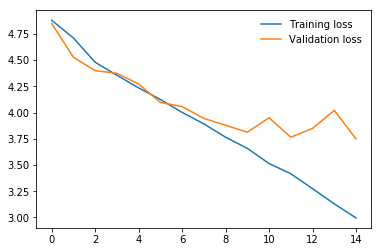

Epoch: 16 	Training Loss: 2.837784 	Validation Loss: 3.763776
Epoch: 17 	Training Loss: 2.689237 	Validation Loss: 4.054875
Epoch: 18 	Training Loss: 2.553463 	Validation Loss: 3.871843
Epoch: 19 	Training Loss: 2.385896 	Validation Loss: 4.060837
Epoch: 20 	Training Loss: 2.243065 	Validation Loss: 4.019438


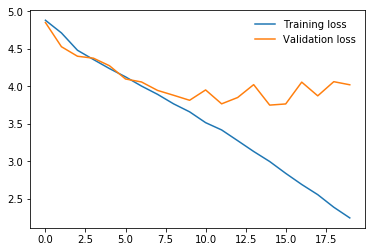

In [ ]:
# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

In [15]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [16]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.708115


Test Accuracy: 15% (127/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
## TODO: Specify data loaders

# SAME LOADER as before
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# will use the same model as before
model_transfer = models.resnet50(pretrained=True)
print(model_transfer.fc)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 117289382.73it/s]


Linear(in_features=2048, out_features=1000, bias=True)


In [21]:
from collections import OrderedDict

# freeze parameters, we don't want to train them      
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the classifier to output our 133 breeds
classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(0.2)),
                          ('fc1', nn.Linear(2048, 133)) # 2048 must match
                          ]))

# attach the classifier
model_transfer.fc = classifier

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- First I downloaded the pretrainde model itself.
- Then printed the end of the model. I need this to determinte the input size of my fully connected layers.
- I freeze the pretrainde layers, because they I unfreezed as default, but I don't want to train them.
- I setup my output layer.
- I attache it to the model.
- If cuda is available I move the model to the gpu.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Epoch: 1 	Training Loss: 2.345605 	Validation Loss: 0.932453
Validation loss decreased (inf --> 0.932453).  Saving model ...
Epoch: 2 	Training Loss: 0.978853 	Validation Loss: 0.722578
Validation loss decreased (0.932453 --> 0.722578).  Saving model ...
Epoch: 3 	Training Loss: 0.795503 	Validation Loss: 0.724412
Epoch: 4 	Training Loss: 0.686569 	Validation Loss: 0.682416
Validation loss decreased (0.722578 --> 0.682416).  Saving model ...
Epoch: 5 	Training Loss: 0.645433 	Validation Loss: 0.620795
Validation loss decreased (0.682416 --> 0.620795).  Saving model ...


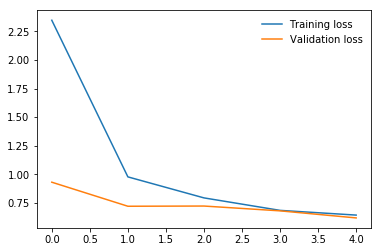

Epoch: 6 	Training Loss: 0.583670 	Validation Loss: 0.629500
Epoch: 7 	Training Loss: 0.537486 	Validation Loss: 0.642238
Epoch: 8 	Training Loss: 0.541932 	Validation Loss: 0.617776
Validation loss decreased (0.620795 --> 0.617776).  Saving model ...
Epoch: 9 	Training Loss: 0.534196 	Validation Loss: 0.617114
Validation loss decreased (0.617776 --> 0.617114).  Saving model ...
Epoch: 10 	Training Loss: 0.499611 	Validation Loss: 0.590777
Validation loss decreased (0.617114 --> 0.590777).  Saving model ...


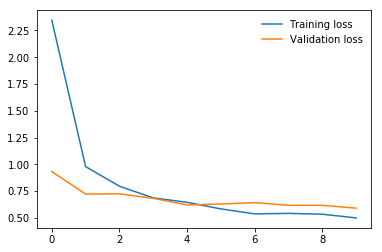

Epoch: 11 	Training Loss: 0.492238 	Validation Loss: 0.576263
Validation loss decreased (0.590777 --> 0.576263).  Saving model ...
Epoch: 12 	Training Loss: 0.499418 	Validation Loss: 0.677158
Epoch: 13 	Training Loss: 0.480958 	Validation Loss: 0.629130
Epoch: 14 	Training Loss: 0.476829 	Validation Loss: 0.572765
Validation loss decreased (0.576263 --> 0.572765).  Saving model ...
Epoch: 15 	Training Loss: 0.460385 	Validation Loss: 0.627616


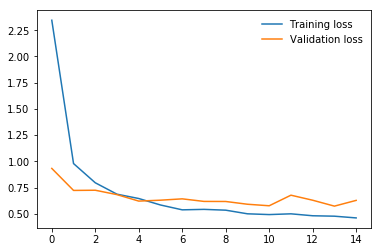

Epoch: 16 	Training Loss: 0.435414 	Validation Loss: 0.670964
Epoch: 17 	Training Loss: 0.422828 	Validation Loss: 0.594460
Epoch: 18 	Training Loss: 0.429817 	Validation Loss: 0.683225
Epoch: 19 	Training Loss: 0.430876 	Validation Loss: 0.655130
Epoch: 20 	Training Loss: 0.423586 	Validation Loss: 0.648207


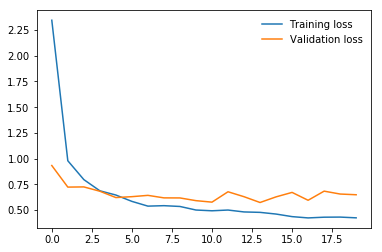

In [26]:
# train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [23]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [26]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.594195


Test Accuracy: 82% (692/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [27]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
print(class_names)

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

In [28]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed

    # get the image 
    img_pil = Image.open(img_path)
    #imshow(np.asarray(img_pil))
    
    # build the transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    data_transform = transforms.Compose([transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    
    # convert to proper input tensor, to deal with png we drop the alpha channel
    img_tensor = data_transform(img_pil)[:3,:,:]
    img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # run trough vgg16
    output = model_transfer(img_tensor)
    
    # get most probable class
    score, class_idx = torch.topk(output, k=1, dim=1)
    
    class_idx = class_idx.data.cpu().numpy()[0][0] # predicted class index
    
    return class_names[class_idx]

print(predict_breed_transfer('images/Labrador_retriever_06457.jpg'))

Labrador retriever


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

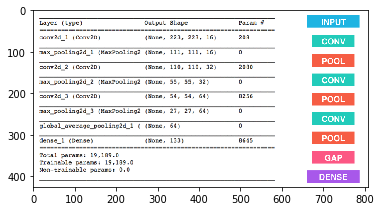

Don't know, maybe Norwegian lundehund? NO, ERROR!!!


In [29]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

# because the face detector had very good performance, we start with the human detector, 
# and if a face is detected we don't check if it can be a dog or not

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # show image
    img_pil = Image.open(img_path)
    plt.imshow(np.asarray(img_pil))
    plt.show()
    
    # calculate breed
    breed = predict_breed_transfer(img_path)
    
    # because the face detector had very good performance, we start with the human detector, 
    # and if a face is detected we don't check if it can be a dog or not   
    if face_detector(img_path):
        print(f'If you were a dog, you would be a {breed} :)')
    # we use our earlier vgg16 based dog detector to check if we found a dog in the image    
    elif dog_detector(img_path):
        print(f'You are a {breed}!')
    else:
        print(f"Don't know, maybe {breed}? NO, ERROR!!!")
        
run_app('images/sample_cnn.png')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- The output is similar to what I thought. The app most of the time finds out if the image is a dog, or a face.

How to improve?
- When my code determines if a picture is a face, it accepts it. But the dog_detector could determine the same picture as a dog. I could improve the code to communicate this doubt.
- Build detectors for different animals, and use them together.
- 

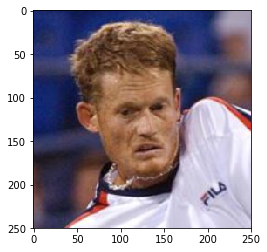

If you were a dog, you would be a Wirehaired pointing griffon :)


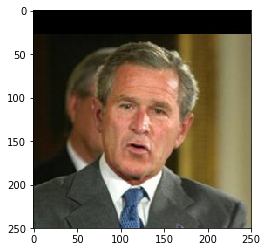

If you were a dog, you would be a Irish wolfhound :)


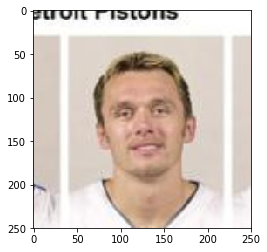

If you were a dog, you would be a Beauceron :)


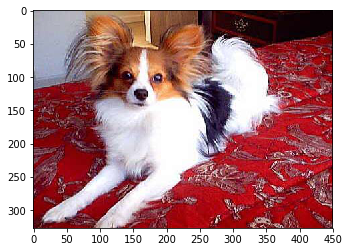

You are a Papillon!


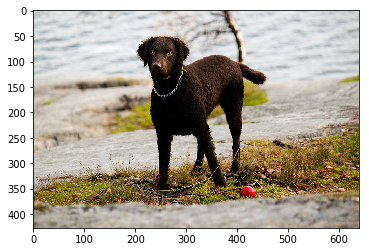

You are a Curly-coated retriever!


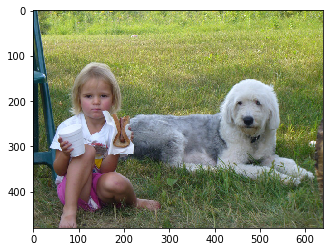

If you were a dog, you would be a Dandie dinmont terrier :)


In [30]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import random

## suggested code, below
for file in np.hstack((random.sample(list(human_files), k=3), random.sample(list(dog_files), k=3))):
    run_app(file)